(lecture05:models-are-functions)=
# Models are functions

Let's now make our first model.
A model is always some kind of function.
It takes some input variables an it maps them to an output quantity of interest.
A good model is one in which the input variables are the causes of the output quantity of interest.
Let's make our first model for the `temperature_raw.xlsx` dataset of {ref}`lecture03:homework`.

In [21]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

Download, and load the data:

In [22]:
!curl -O 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/temperature_raw.xlsx'

import pandas as pd
df = pd.read_excel('temperature_raw.xlsx')
df = df.dropna(axis=0)
df.head().round(2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277k  100  277k    0     0  2217k      0 --:--:-- --:--:-- --:--:-- 2223k


,household,date,score,t_out,t_unit,hvac
0,a1,2018-01-07,100.0,4.28,66.69,246.47
1,a10,2018-01-07,100.0,4.28,66.36,5.49
2,a11,2018-01-07,58.0,4.28,71.55,402.09
3,a12,2018-01-07,64.0,4.28,73.43,211.69
4,a13,2018-01-07,100.0,4.28,63.92,0.85


The output we want to look at is `hvac`, the weekly energy consumption of a unit.
What affects the weekly energy consumption?
Well, obviously the average external temperature `t_out`.
Let's do the scatter plot of the two variables to see what kind of relationship we have:

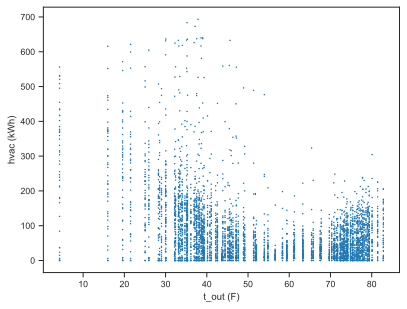

In [23]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'], s=0.5)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
save_for_book(fig, 'ch5.fig4')

Okay, it's kind of a mess, but we see four important trends:
+ The energy consumption goes up when the average external temperature gets very cold. This makes sense because for very cold external temperatures the occupants are running their heating.
+ The energy consuption is at a minimum when the external temperature is around 60 degrees F.
This also makes sense. When the weather is nice, the occupants shut down their heating.
+ Then, the energy consumption also goes up when the external temperature becomes higher.
This is because the occupants start using their cooling.
+ Finally, when the average external temperature is around 60 degrees F, the energy consumption is at a minimum, but it does not become exactly zero.

In summary:
+ `hvac` $\downarrow$ if `t_out` $< 60$ deg F.
+ `hvac` $\uparrow$ if `t_out` $> 60$ deg F.
+ When `t_out` is 60, there is a minimal, nonzero average `hvac`.

What is the simplest function that captures these trends?
Well, that would be a parabola centered at 60 degrees F.
This one:

$$
\text{hvac} = \text{hvac}(\text{t\_out}) = a (\text{t\_out} - 60)^2 + b,
$$

for some parameters $a$ and $b$ that we need to pick.
This is our first model!
This is a function.
Let's implement the function in Python:

In [24]:
def hvac_model(t_out, a, b, t_out_min=60):
    """A naive model of weekly HVAC energy consumption (kWh) as a function of external temperature t_out.
    The mathematical form of the model is:
    
        hvac = a * (t_out - t_out_min)^2 + b
    
    Arguments:
    t_out      -   The average external temperature in degrees F (average over a week).
    a          -   A parameter to be calibrated using observed data. In units of kWh / (deg F)^2.
    b          -   Another parameter to be calibrated using observed data. This is in units of kWh.
                   It is the energy consumption when the HVAC system is not used.
    t_out_min  -   The external temperature above which the occupants feel comfortable without using
                   their HVAC system.
    
    Returns: The weekly HVAC energy consumption in kWh.
    """
    return a * (t_out - t_out_min) ** 2 + b

Now we have to calibrate the parameters.

## Calibrating our first model manually

Let's try to manually pick this parameter $a$.
We are going to do this:
+ pick a value for $a$
+ plot the scatter plot of `t_out` and `hvac`
+ plot the model `hvac(t_out)`
+ compare the results

Here we go:

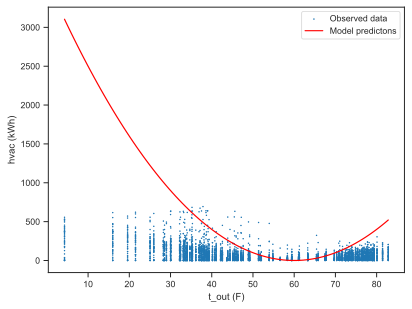

In [25]:
import numpy as np

a = 1 # in kWh / F^2
b = 0 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data', s=0.5)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

This is not every good.
Maybe my $a$ parameter is too big.
Let me try something smaller.

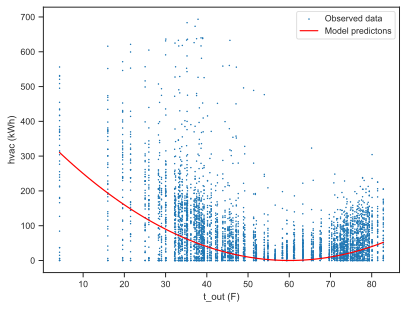

In [26]:
a = 0.1 # in kWh / F^2
b = 0 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data', s=0.5)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

This looks better.
But I would like to push the model up a little bit.
I can do this by varying the $b$:

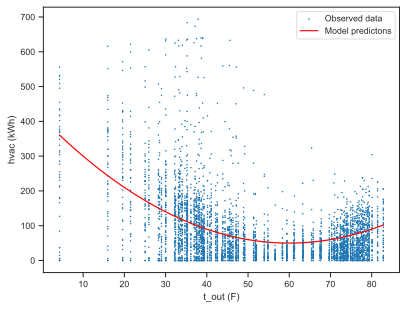

In [27]:
a = 0.1 # in kWh / F^2
b = 50 # in kWh
fig, ax = make_full_width_fig()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data', s=0.5)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best')
save_for_book(fig, 'ch5.fig5')

For manual parameter calibration, this looks pretty good!

In the technical jargon, we have made a regression model.
In particular, we have made a linear regression model.
The correct way to calibrate the parameters of a linear regression model is via the so-called least squares method.
We will learn the mathematics of least squares in a {ref}`lecture13`.

## Making predictions with our model

Let's make some predictions with our model.
Let's look at high temperatures which are missing form our dataset.
Say from 80 deg. F to 110 deg. F, what weekly average HVAC energy consumption should we expect?

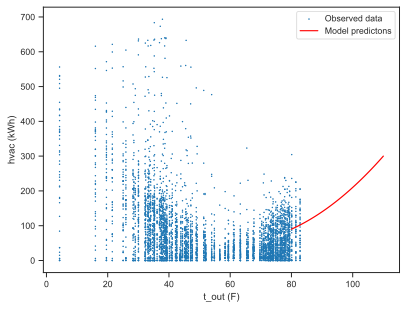

In [28]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'], label='Observed data', s=0.5)
t_outs = np.linspace(80, 110, 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best')
save_for_book(fig, 'ch5.fig6')

Note that even though the prediction is unlikely to be correct, it can still be very useful.
For example, you can use it to plan how much electricity load you are likely to need in an extreme heat event.

## Questions

For simple models like the one above, you can use Python's interactive plotting capabilities to make an even better manual choice of the parameters.
I am not going to explain how the code below works, but if you feel like digging deeper on your own time, then be my guest!

In [29]:
%matplotlib inline
import ipywidgets as widgets
from IPython.display import clear_output

out = widgets.Output()

def draw(a, b, t_out_min):
    plt.figure(figsize=(6,4))
    plt.scatter(df['t_out'], df['hvac'], s=12, label='Observed data')
    t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 200)
    plt.plot(t_outs, hvac_model(t_outs, a, b, t_out_min=t_out_min), label='Model predictions')
    plt.xlabel('t_out (°F)')
    plt.ylabel('hvac (kWh)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def update(a=0.1, b=50.0, t_out_min=float(df['t_out'].min())):
    with out:
        clear_output(wait=True)
        draw(a, b, t_out_min)

controls = widgets.interact(
    update,
    a=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='a'),
    b=widgets.FloatSlider(value=50.0, min=0.0, max=200.0, step=1.0, description='b'),
    t_out_min=widgets.FloatSlider(
        value=float(df['t_out'].min()),
        min=float(df['t_out'].min()),
        max=float(df['t_out'].max()),
        step=1.0,
        description='t_out_min'
    )
)
display(out)

interactive(children=(FloatSlider(value=0.1, description='a', max=1.0, step=0.01), FloatSlider(value=50.0, des…

Output()

+ Play with the interactive plot above and see if you can find a better set of parameters. You need to run this Jupyter notebook on Google Colab of course.